In [ ]:
import librosa
import numpy as np
import torchaudio
import random
import torch
import matplotlib.pyplot as plt
from librosa.display import specshow

In [ ]:
from google.colab import drive
import warnings

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wv = "/content/drive/MyDrive/fluent-tag/pa-nu/pa-nu-0101-0-2-v-000.wav"
y, sr = librosa.load(wv)
wv2 = "/content/drive/MyDrive/fluent-tag/pa-nu/pa-nu-0101-0-2-v-002.wav"
y2, sr2 = librosa.load(wv2)


def to_melspec(y):
    frame_length = 0.025
    frame_stride = 0.010
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    frame_length = input_nfft/sr
    mel_spec = librosa.feature.melspectrogram(y=y, n_mels=128, n_fft=input_nfft, hop_length=input_stride)
    return mel_spec

def show(S):
    plt.figure(figsize=(10, 4))
    specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.tight_layout()
    plt.show()

In [ ]:
mel_spec = to_melspec(y)
mel_spec2 = to_melspec(y2)

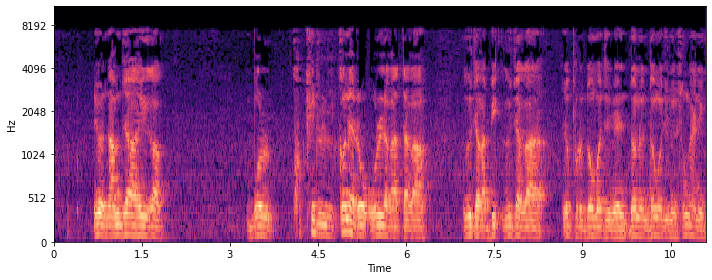

In [ ]:
show(mel_spec)

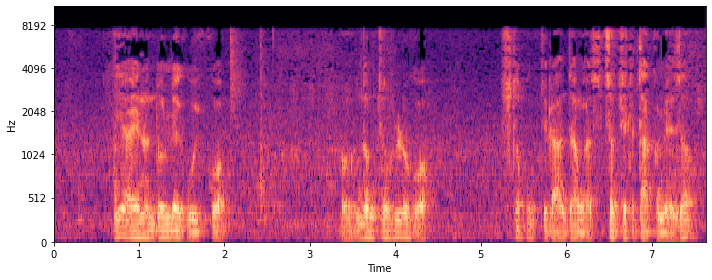

In [ ]:
show(mel_spec2)

In [ ]:
class AudioAugment():
    def __init__(self):
        self.alpha = .4

    def change_pitch(self, y, sr): # y, sr = librosa.load(wavfile)
        y_pitch = y.copy()
        bins_per_octave = 12
        pitch_pm = 2
        pitch_change = pitch_pm * 2 * (np.random.uniform())
        y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), sr, n_steps=pitch_change,
                                            bins_per_octave=bins_per_octave)
        return y_pitch

    def value_aug(self, y):
        y_aug = y.copy()
        dyn_change = np.random.uniform(low=1.5, high=3)
        y_aug = y_aug * dyn_change
        return y_aug

    def add_noise(self, y):
        noise = np.random.randn(len(y))
        data_noise = y + 0.005 * noise
        return data_noise

    def shift(self, y):
        return np.roll(y, 1600)

    def hpss(self, y):
        # 보통 harmonic part만 사용한다.
        y_harmonic, y_percussive = librosa.effects.hpss(y.astype('float64'))
        return y_harmonic

    def change_pitch_and_speed(self, y):
        y_pitch_speed = y.copy()
        length_change = np.random.uniform(low=0.8, high=1)
        speed_fac = 1.0 / length_change
        tmp = np.interp(np.arange(0, len(y_pitch_speed), speed_fac), np.arange(0, len(y_pitch_speed)), y_pitch_speed)
        minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
        y_pitch_speed *= 0
        y_pitch_speed[0:minlen] = tmp[0:minlen]
        return y_pitch_speed

    def resample(self, y, new_sample_rate=8000):
        return torchaudio.transforms.Resample(16000, new_sample_rate)(torch.tensor(y))

    def time_stretching(self, y, rate=1.2):
        y_strech= librosa.effects.time_stretch(y, rate)
        return y_strech
    
    def time_masking(self, mel_spec, time_mask_param=35): # for torch
        time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param, iid_masks=False)
        return time_mask(torch.tensor(mel_spec))

    def freq_masking(self, mel_spec, freq_mask_param=15): # for torch
        freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param, iid_masks=False) # iid_masks: 배치마다 같은 마스킹?
        return freq_mask(torch.tensor(mel_spec))

    def freq_mask(self, x, num=1, mask_size=10, verbose=False):
        num_bins = x.shape[0]
        for i in range(num):
            f = random.randrange(0, mask_size + 1)
            if f == 0 or f >= num_bins: continue
            f_low = random.randrange(0, num_bins - f)
            f_high = f_low + f
            x[f_low:f_high] =0
        if verbose==True: return x, f_low, f_high
        else: return x

    def time_mask(self, x, num=1, mask_size=10, verbose =False):
        num_frames = x.shape[1]
        for i in range(num):
            t = random.randrange(0, mask_size + 1)
            if t == 0 or t >= num_frames: continue
            t_beg = random.randrange(0, num_frames - t)
            t_end = t_beg + t
            x[:, t_beg:t_end] = 0
        if verbose==True: return x, t_beg, t_end
        else: return x
    
    def specmix(self,x1, x2, mask_size=10):
        cut = min(x1.shape[1], x2.shape[1])
        x1, x2 = x1[:,:cut], x2[:, :cut]
        x1, f_low, f_high = self.freq_mask(x1, verbose=True, mask_size=mask_size)
        x1, t_beg, t_end = self.time_mask(x1, verbose=True, mask_size=mask_size)
        x2[:f_low, :t_beg], x2[:f_low,  t_end:], x2[f_high:, t_end:], x2[f_high:,:t_beg] =  0,0,0,0
        new_x = x1+x2
        return x1, x2, new_x


In [ ]:
aug = AudioAugment()

In [ ]:
x1, x2, nx = aug.specmix(mel_spec, mel_spec2, 30)

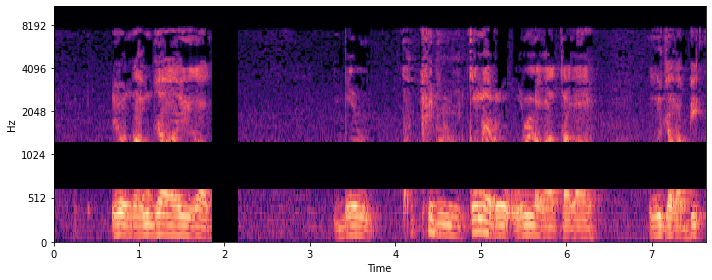

In [ ]:
show(x1)

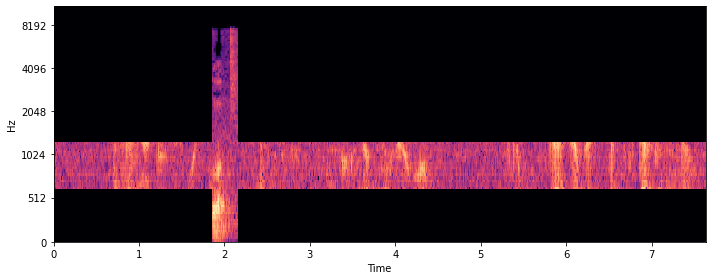

In [ ]:
show(x2)

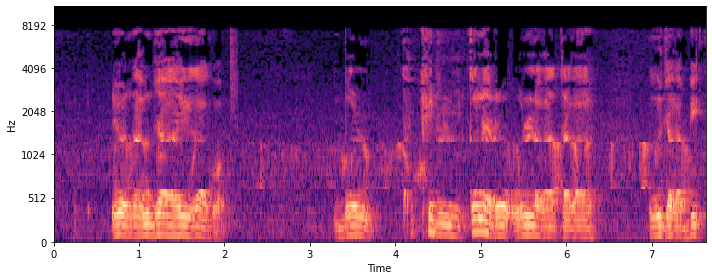

In [ ]:
show(nx)

In [ ]:
y

array([0.0028769 , 0.00192336, 0.00134447, ..., 0.01252077, 0.0092513 ,
       0.        ], dtype=float32)

In [ ]:
aug.change_pitch(y, sr)

array([0.00257844, 0.00179196, 0.00159946, ..., 0.01114352, 0.01084111,
       0.        ])

In [ ]:
aug.change_pitch_and_speed(y)

array([0.0028769 , 0.00180329, 0.00159137, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
aug.shift(y)

array([0.05679266, 0.04820955, 0.03838073, ..., 0.05678086, 0.05692261,
       0.05616951], dtype=float32)

In [ ]:
aug.add_noise(y)

array([-3.87963488e-03,  2.43063215e-03,  3.92542317e-05, ...,
        1.77076738e-02, -6.95942353e-04, -4.91771131e-04])

In [ ]:
aug.value_aug(y)

array([0.00760703, 0.00508569, 0.00355502, ..., 0.03310706, 0.02446201,
       0.        ], dtype=float32)

In [ ]:
aug.hpss(y)

array([0.00144262, 0.00082526, 0.0006221 , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
aug.resample(torch.tensor(y))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([0.0018, 0.0019, 0.0009,  ..., 0.0110, 0.0124, 0.0021])

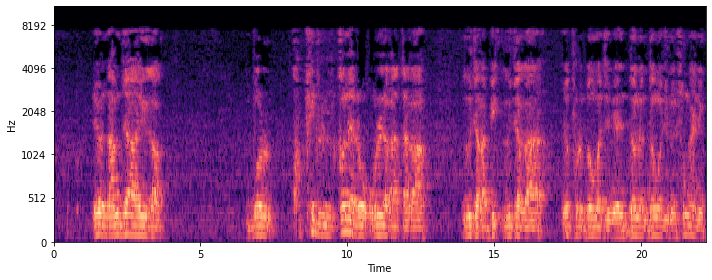

In [ ]:
time = aug.time_stretching(y, 0.5)
show(to_melspec(time))

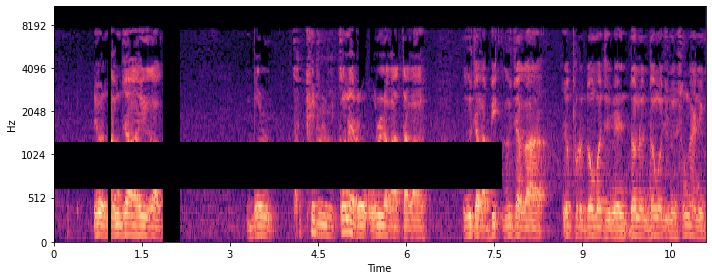

In [ ]:
time = aug.time_mask(mel_spec)
show(time)

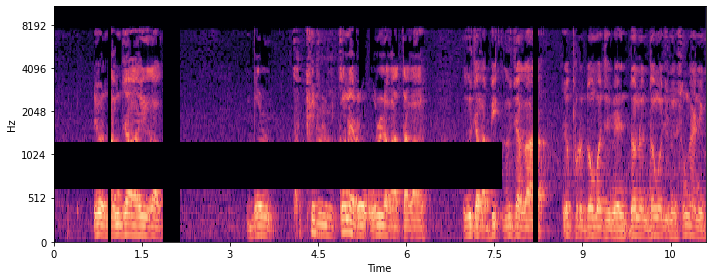

In [ ]:
mask = aug.time_masking(mel_spec)
show(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


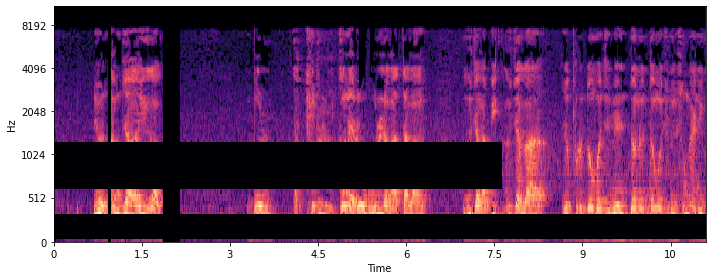

In [ ]:
freq = aug.freq_masking(mel_spec)
plus = aug.freq_masking(mask)
show(freq)

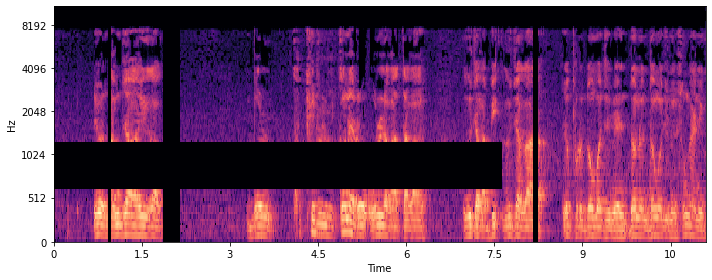

In [ ]:
show(plus)

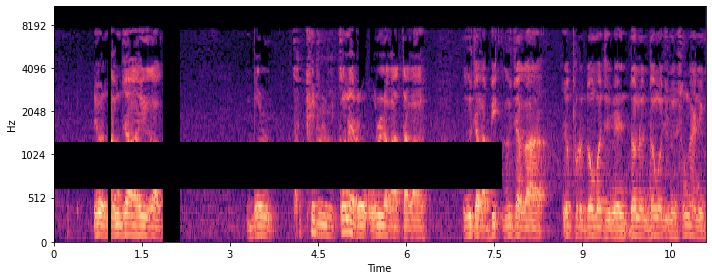

In [ ]:
freq = aug.freq_mask(mel_spec)
show(freq)